# Project: Recognizing Traffic Signs Using Deep Learning
### Scope: Classifier: LeNet-5
##### Author: Ashish Panchal (epababl03.ashishp@iima.ac.in)

In [9]:
import numpy as np
import pandas as pd
import sys
import os
import pickle as p
import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

sys.path.insert(2, os.path.abspath('../src/data'))
from datapreprocessor import preprocess


In [10]:
#Load stored data

#No. of classes
%store -r n_classes

# class labels
%store -r signs

#Final preprocessed Training Dataset
%store -r X_train_preprocessed
%store -r y_train_final

#Final preprocessed Test Dataset
%store -r X_test_preprocessed
%store -r y_test


#Final preprocessed Validation Dataset
%store -r X_valid_preprocessed 
%store -r y_valid

EPOCHS = 30
BATCH_SIZE = 64
DIR = '../Saved_Models/LeNet'

model_acc_df = pd.DataFrame(columns=['EPOCH', 'LeNet_Train_Acc','LeNet_Train_Loss', 'LeNet_Valid_Acc','LenNet_Valid_Loss'
                                    , 'VGGNet_Train_Acc','VGGNet_Train_Loss', 'VGGNet_Valid_Acc','VGGNet_Valid_Loss'])


## 6.1.  Model Architecture

In this step, we will design and implement a deep learning model that learns to recognize traffic signs from our dataset German Traffic Sign Dataset.

We'll use Convolutional Neural Networks to classify the images in this dataset. The reason behind choosing ConvNets is that they are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They automatically learn hierarchies of invariant features at every level from data. We will implement two of the most famous ConvNets. Our goal is to reach an accuracy of +95% on the validation set.

I'll start by explaining each network architecture, then implement it using TensorFlow.

Notes:

We specify the <mark>learning rate of 0.001</mark>, which tells the network how quickly to update the weights.
We <mark>minimize the loss function using the Adaptive Moment Estimation (Adam) Algorithm</mark>. Adam is an optimization algorithm introduced by D. Kingma and J. Lei Ba in a 2015 paper named Adam: A Method for Stochastic Optimization. Adam algorithm computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop algorithms, Adam also keeps an exponentially decaying average of past gradients mtmt, similar to momentum algorithm, which in turn produce better results.
we will run minimize() function on the optimizer which use backprobagation to update the network and minimize our training loss.

### 1.1 LeNet-5

#### LeNet-5 

NeNet-5 is a convolutional network designed for handwritten and machine-printed character recognition. It was introduced by the famous Yann LeCun in his paper Gradient-Based Learning Applied to Document Recognition in 1998. Although this ConvNet is intended to classify hand-written digits, we're confident it have a very high accuracy when dealing with traffic signs, given that both hand-written digits and traffic signs are given to the computer in the form of pixel images.

The LeNet-5 architecture consists of two sets of convolutional and average pooling layers, followed by a flattening convolutional layer, then two fully-connected layers and finally a softmax classifier.

![Alt](../reports/figures/LeNet_Original_Image.jpg "LeNet-5 Architecture")
<center>LeNet-5 Architecture - Original Image published in [LeCun et al., 1998]</center>


1. First Layer:

    The input for LeNet-5 is a 32×32 grayscale image which passes through the first convolutional layer with 6 feature maps or filters having size
    5×5 and a stride of one. The image dimensions changes from 32x32x1 to 28x28x6.
![Alt](../reports/figures/LeNet_Layer1.jpg "LeNet-5 Architecture- First Layer")

2. Second Layer:

    Then the LeNet-5 applies average pooling layer or sub-sampling layer with a filter size 2×2 and a stride of two. The resulting image
    dimensions will be reduced to 14x14x6.
![Alt](../reports/figures/LeNet_Layer2.jpg "LeNet-5 Architecture- Second Layer")

3. Third Layer:

    Next, there is a second convolutional layer with 16 feature maps having size 5×5 and a stride of 1. In this layer, only 10 out of 16 feature
    maps are connected to 6 feature maps of the previous layer as shown below.

![Alt](../reports/figures/image.png "LeNet-5 Architecture- Second Layer")
Snapshot of TABLE 1 from [LeCun et al., 1998]

The main reason is to break the symmetry in the network and keeps the number of connections within reasonable bounds. That’s why the number of training parameters in this layers are 1516 instead of 2400 and similarly, the number of connections are 151600 instead of 240000.
![Alt](../reports/figures/LeNet_Layer3.jpg "LeNet-5 Architecture- Third Layer")


4. Fourth Layer:

    The fourth layer (S4) is again an average pooling layer with filter size 2×2 and a stride of 2. This layer is the same as the second layer
    (S2) except it has 16 feature maps so the output will be reduced to 5x5x16.
![Alt](../reports/figures/LeNet_Layer4.jpg "LeNet-5 Architecture- Fourth Layer")


5. Fifth Layer:

    The fifth layer (C5) is a fully connected convolutional layer with 120 feature maps each of size 1×1. Each of the 120 units in C5 is connected
    to all the 400 nodes (5x5x16) in the fourth layer S4.
![Alt](../reports/figures/LeNet_Layer5.jpg "LeNet-5 Architecture- Fifth Layer")


6. Sixth Layer:

    The sixth layer is a fully connected layer (F6) with 84 units.
![Alt](../reports/figures/LeNet_Layer6.jpg "LeNet-5 Architecture- Sixth Layer")

__LeNet-5 architecture:__

This ConvNet follows these steps:

Input => Convolution => ReLU => Pooling => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected

__Layer 1__ (Convolutional): The output shape should be 28x28x6.

__Activation.__ Your choice of activation function.

__Pooling.__ The output shape should be 14x14x6.

__Layer 2 (Convolutional):__ The output shape should be 10x10x16.

__Activation.__ Your choice of activation function.

__Pooling.__ The output shape should be 5x5x16.

__Flattening:__ Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

__Layer 3 (Fully Connected)__: This should have 120 outputs.

__Activation.__ Your choice of activation function.

__Layer 4 (Fully Connected):__ This should have 84 outputs.

__Activation.__ Your choice of activation function.

__Layer 5 (Fully Connected):__ This should have 43 outputs.

In [11]:
class LaNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
        
        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
        
        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
        
        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))


        # Saving all variables
        self.saver = tf.train.Saver()
    
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        #print(type(X_data))
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    def evaluate_loss(self, X_data, y_data, BATCH_SIZE=64):
        #print('evaluate_loss:',type(X_data))
        num_examples = len(X_data)
        total_loss = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            loss = sess.run(self.loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_loss += (loss * len(batch_x))
        return total_loss / num_examples

## 2. Model Training and Evaluation

In this step, we will train our model using normalized_images, then we'll compute softmax cross entropy between logits and labels to measure the model's error probability.

x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

In [13]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [20]:
LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"
normalized_images = X_train_preprocessed
y_train = y_train_final
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train_final)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
            
        training_accuracy = LeNet_Model.evaluate(normalized_images, y_train)
        training_loss = LeNet_Model.evaluate_loss(normalized_images, y_train)
        
        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        validation_loss = LeNet_Model.evaluate_loss(X_valid_preprocessed, y_valid)
        
        print("EPOCH {} : Training Accuracy = {:.3f}%".format(i+1, (training_accuracy*100)))
        print("EPOCH {} : Training Loss = {:.3f}%".format(i+1, (training_loss*100)))
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
        print("EPOCH {} : Validation Loss = {:.3f}%".format(i+1, (validation_loss*100)))
        print('')
        model_acc_df.loc[i, 'EPOCH'] = i+1
        model_acc_df.loc[i, 'LeNet_Train_Acc'] = (training_accuracy*100)
        model_acc_df.loc[i, 'LeNet_Train_Loss'] = (training_loss*100)
        model_acc_df.loc[i, 'LeNet_Valid_Acc'] = (validation_accuracy*100)
        model_acc_df.loc[i, 'LenNet_Valid_Loss'] = (validation_loss*100)
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")
    model_acc_df.to_csv('../reports/cnn_data.csv', index = False, header=True)

Training ...

EPOCH 1 : Training Accuracy = 75.267%
EPOCH 1 : Training Loss = 80.257%
EPOCH 1 : Validation Accuracy = 75.374%
EPOCH 1 : Validation Loss = 78.713%

EPOCH 2 : Training Accuracy = 87.969%
EPOCH 2 : Training Loss = 41.514%
EPOCH 2 : Validation Accuracy = 85.034%
EPOCH 2 : Validation Loss = 48.779%

EPOCH 3 : Training Accuracy = 89.717%
EPOCH 3 : Training Loss = 32.847%
EPOCH 3 : Validation Accuracy = 84.127%
EPOCH 3 : Validation Loss = 48.683%

EPOCH 4 : Training Accuracy = 90.902%
EPOCH 4 : Training Loss = 28.500%
EPOCH 4 : Validation Accuracy = 84.512%
EPOCH 4 : Validation Loss = 54.353%

EPOCH 5 : Training Accuracy = 95.089%
EPOCH 5 : Training Loss = 16.442%
EPOCH 5 : Validation Accuracy = 89.184%
EPOCH 5 : Validation Loss = 37.184%

EPOCH 6 : Training Accuracy = 95.920%
EPOCH 6 : Training Loss = 13.304%
EPOCH 6 : Validation Accuracy = 89.615%
EPOCH 6 : Validation Loss = 34.937%

EPOCH 7 : Training Accuracy = 95.425%
EPOCH 7 : Training Loss = 14.089%
EPOCH 7 : Validation

In [21]:
#Load accuracy data
model_acc_df = pd.read_csv('../reports/cnn_data.csv')

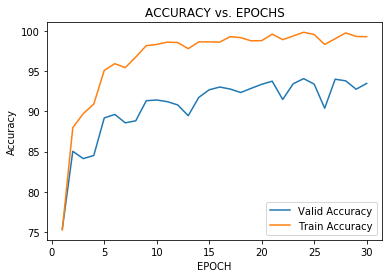

In [30]:
# gca stands for 'get current axis'

ax = plt.gca()

plt.title('ACCURACY vs. EPOCHS')
plt.ylabel('Accuracy')

model_acc_df.plot(kind='line',x='EPOCH',y='LeNet_Valid_Acc',ax=ax, label='Valid Accuracy')
model_acc_df.plot(kind='line',x='EPOCH',y='LeNet_Train_Acc', ax=ax, label='Train Accuracy')

plt.savefig('../plots/classifier/lenet/valid_train_acc.png')
plt.show()


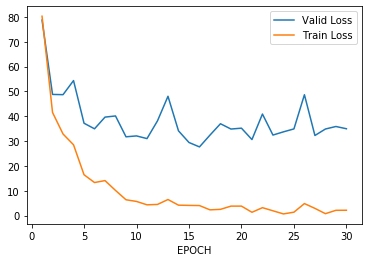

In [31]:
ax = plt.gca()
model_acc_df.plot(kind='line',x='EPOCH',y='LenNet_Valid_Loss',ax=ax, label='Valid Loss')
model_acc_df.plot(kind='line',x='EPOCH',y='LeNet_Train_Loss', ax=ax, label='Train Loss')

plt.savefig('../plots/classifier/lenet/valid_train_loss.png')
plt.show()

## 3.  Testing the Model using the Test Set
Now, we'll use the testing set to measure the accuracy of the model over unknown examples.

In [33]:
with tf.Session() as sess:
    LeNet_Model.saver.restore(sess, os.path.join('/Users/apanchal/EPABA/iima-epaba-batch03/Saved_Models/LeNet/', model_name))
    y_pred = LeNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from /Users/apanchal/EPABA/iima-epaba-batch03/Saved_Models/LeNet/LeNet
Test Accuracy = 89.5%


Now we'll plot the confusion matrix to see where the model actually fails.

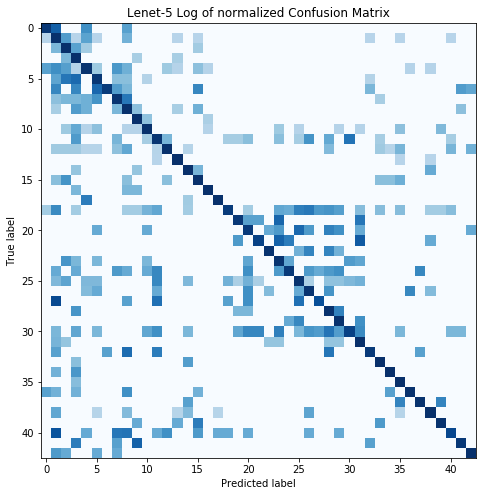

In [35]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Lenet-5 Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('../plots/classifier/lenet/LeNet_confusion_mat.png')
plt.show()

__Observation:__

1. I observe some clusters in the confusion matrix above. It turns out that the various speed limits are sometimes misclassified among themselves.
   Similarly, traffic signs with traingular shape are misclassified among themselves. 

2. We can further improve on the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify
   finer features (such as the actual speed limit).

## 4.Testing the LeNet Model on New Images

In [37]:
### Loading and resizing new test images
new_test_images = []
path = '../data/traffic_sign_images/'
for image in sorted(os.listdir(path)):
    print('Reading:', path+image)
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17, 1,  14, 30, 25, 29, 11, 8,  31, 31, 30, 4, 1, 2, 27, 18]
print("Number of new testing examples: ", len(new_test_images), 'Signs:', len(new_IDs))

Reading: ../data/traffic_sign_images/001.jpg
Reading: ../data/traffic_sign_images/002.jpg
Reading: ../data/traffic_sign_images/003.jpg
Reading: ../data/traffic_sign_images/004.jpg
Reading: ../data/traffic_sign_images/005.jpg
Reading: ../data/traffic_sign_images/006.jpg
Reading: ../data/traffic_sign_images/007.jpg
Reading: ../data/traffic_sign_images/008.jpg
Reading: ../data/traffic_sign_images/009.jpg
Reading: ../data/traffic_sign_images/010.jpg
Reading: ../data/traffic_sign_images/011.jpg
Reading: ../data/traffic_sign_images/012.jpg
Reading: ../data/traffic_sign_images/013.jpg
Reading: ../data/traffic_sign_images/014.jpg
Reading: ../data/traffic_sign_images/015.jpg
Reading: ../data/traffic_sign_images/016.jpg
Reading: ../data/traffic_sign_images/017.jpg
Reading: ../data/traffic_sign_images/018.jpg
Reading: ../data/traffic_sign_images/019.jpg
Reading: ../data/traffic_sign_images/020.jpg
Number of new testing examples:  20 Signs: 20


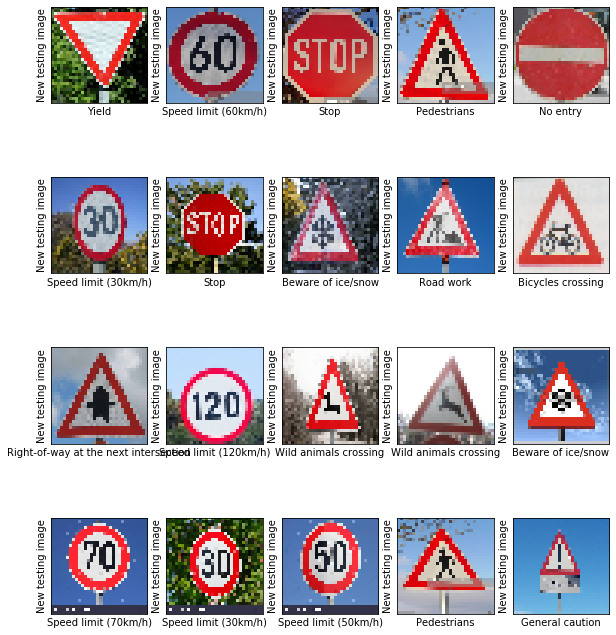

In [38]:
plt.figure(figsize=(10, 12))
for i in range(len(new_test_images)):
    plt.subplot(4, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
#plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

These test images include some easy to predict signs, and other signs are considered hard for the model to predict.

For instance, we have easy to predict signs like the "Stop" and the "No entry". The two signs are clear and belong to classes where the model can predict with high accuracy.

On the other hand, we have signs belong to classes where has poor accuracy, like the "Speed limit" sign, because as stated above it turns out that the various speed limits are sometimes misclassified among themselves, and the "Pedestrians" sign, because traffic signs with traingular shape are misclassified among themselves.

In [39]:
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from /Users/apanchal/EPABA/iima-epaba-batch03/Saved_Models/LeNet/LeNet
New Images Test Accuracy = 55.0%


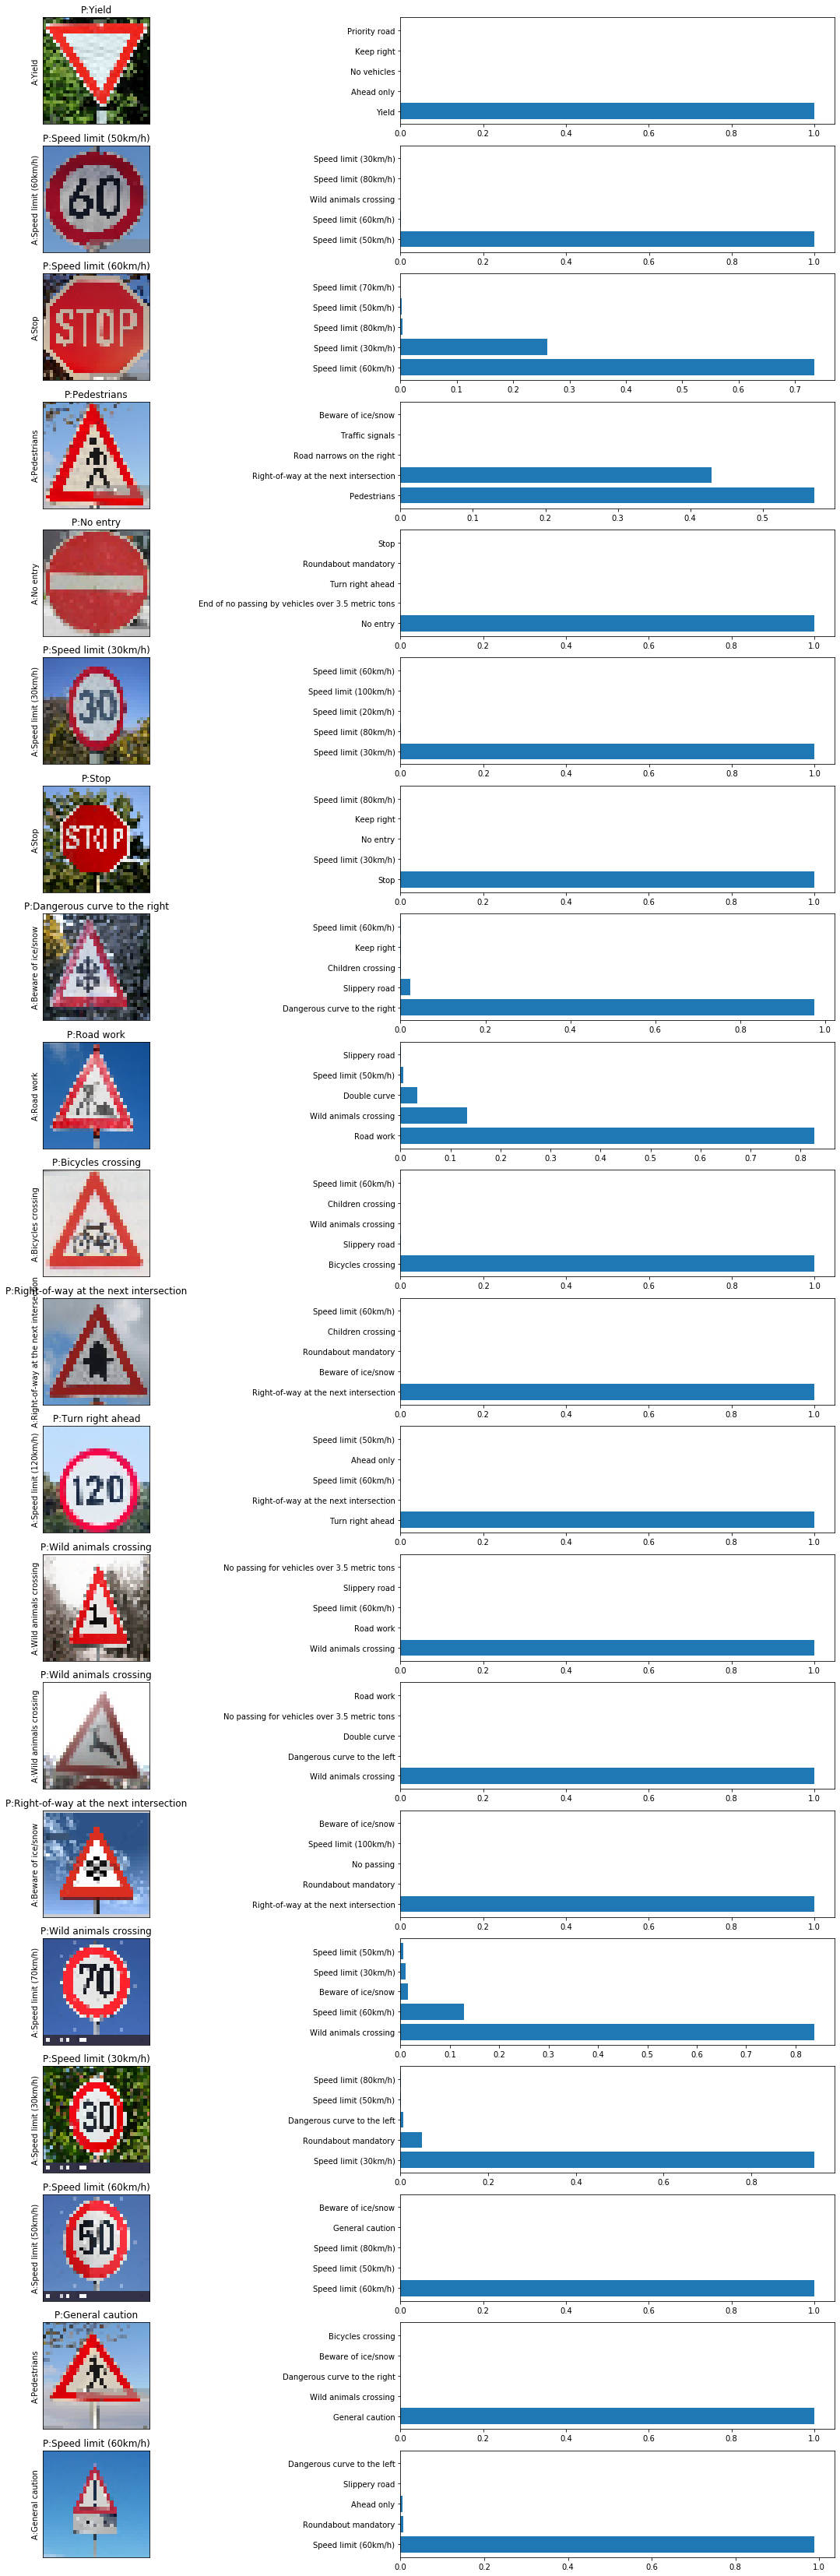

In [41]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        LeNet_Model.saver.restore(sess, os.path.join('/Users/apanchal/EPABA/iima-epaba-batch03/Saved_Models/LeNet/', "LeNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(LeNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
#print('new_test_images_preprocessed', new_test_images_preprocessed.shape[0])
for i in enumerate(new_test_images_preprocessed):
    #print('new_IDs[i[0]]:',new_IDs[i[0]])
    #print('np.asarray(y_pred[i[0]])[0]:',np.asarray(y_pred[i[0]])[0])
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy +=1
print("New Images Test Accuracy = {:.1f}%".format((test_accuracy/new_test_images_preprocessed.shape[0])*100))

plt.figure(figsize=(22, 60))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    actual = signs[new_IDs[i]]
    #print('LABEL:',actual)
    #plt.title('Actual:'+actual+'\nPredicted: '+signs[y_pred[i][0]])
    plt.title('P:'+signs[y_pred[i][0]])
    plt.ylabel('A:'+actual)
    #plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()